In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [97]:
img = cv2.imread('img/outdoor/hazy/0001_0.8_0.2.jpg')
# img = cv2.imread('img/realworld/BJ_Baidu_394.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

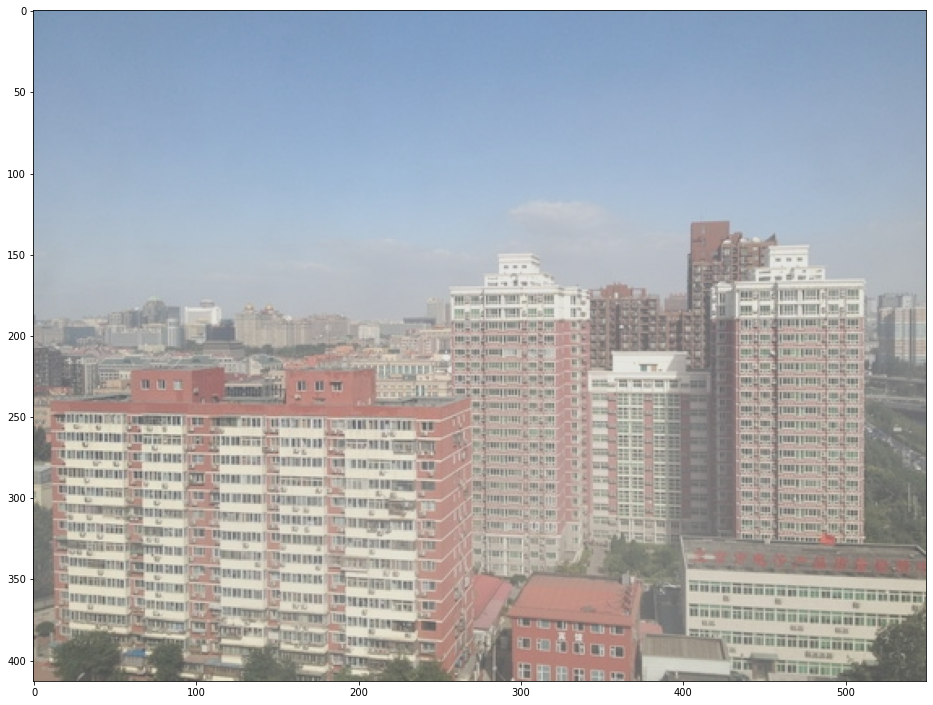

In [98]:
plt.figure(figsize=(16,16))
plt.imshow(img, cmap='gray')

In [99]:
def create_mask(img, mode, D0):
    mask = np.zeros_like(img, dtype=np.float64)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    if mode == 'gaussian':
        # create black circle on white background for high pass filter
        radius = 13
        cv2.circle(mask, (cx,cy), radius, 1, -1)
        mask = 1 - mask
        # antialias mask via blurring
        mask = cv2.GaussianBlur(mask, (47,47), 0)
        
    elif mode == 'butterworth':
        for u in range(mask.shape[0]):
            for v in range(mask.shape[1]):
                D_squared = (u - cy)**2 + (v - cx)**2
                if D_squared == 0:
                    continue
                mask[u, v] = 1 / (1 + (D0 ** 2) / D_squared)
    return mask

In [100]:
def homophoric_filtering(img, mode, D0):
    # replace zero values
    img_float = np.float64(img)
    img_float[img_float == 0] = 0.001
    # take ln of image
    img_log = np.log(np.float64(img_float), dtype=np.float64)

    # do dft saving as complex output
    dft = np.fft.fft2(img_log, axes=(0,1))

    # apply shift of origin to center of image
    dft_shift = np.fft.fftshift(dft)

    mask = create_mask(img, mode, D0)

    # apply mask to dft_shift
    dft_shift_filtered = np.multiply(dft_shift,mask)

    # shift origin from center to upper left corner
    back_ishift = np.fft.ifftshift(dft_shift_filtered)

    # do idft saving as complex
    img_back = np.fft.ifft2(back_ishift, axes=(0,1))

    # combine complex real and imaginary components to form (the magnitude for) the original image again
    img_back = np.abs(img_back)

    # apply exp to reverse the earlier log
    img_homomorphic = np.exp(img_back, dtype=np.float64)

    # scale result
    img_homomorphic = cv2.normalize(img_homomorphic, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return img_homomorphic

In [101]:
def homophoric_filtering_3d(img, mode, D0):
    red = homophoric_filtering(img[:, :, 0], mode, D0)
    green = homophoric_filtering(img[:, :, 1], mode, D0)
    blue = homophoric_filtering(img[:, :, 2], mode, D0)
    new_img = np.dstack((red, green, blue))
    return new_img

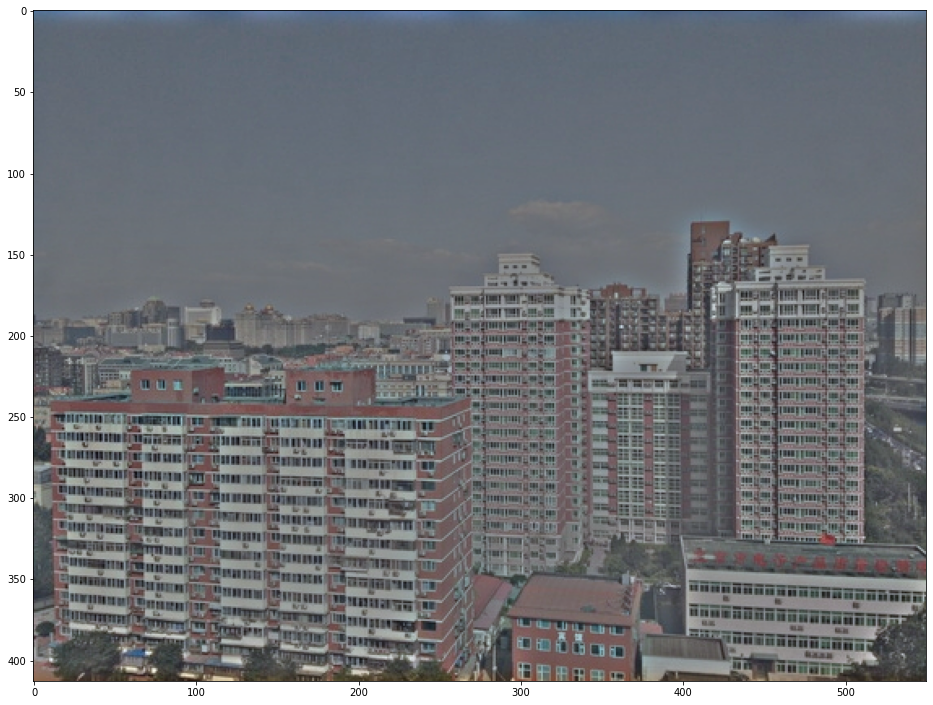

In [102]:
new_img = homophoric_filtering_3d(img, 'gaussian', 50)
plt.figure(figsize=(16,16))
plt.imshow(new_img)

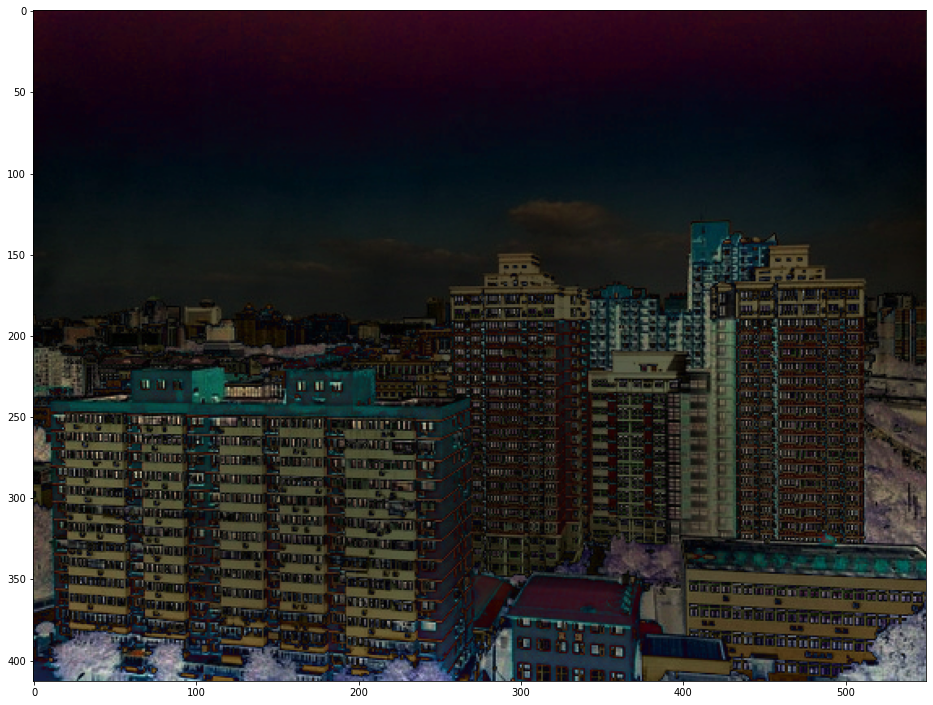

In [103]:
new_img = homophoric_filtering_3d(img, 'butterworth', 1)
# new_img = homophoric_filtering(img, 'butterworth', 5)
plt.figure(figsize=(16,16))
plt.imshow(new_img, cmap='gray')